In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import random
from src.utils_standardize import DataNormalizer

site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:,[0,2,7]]
testdata = pd.read_csv('data/test.csv')
testdata = testdata[testdata.columns[~testdata.columns.str.startswith("cbcl")]]
traindata = pd.read_csv('data/train.csv')
traindata = traindata[traindata.columns[~traindata.columns.str.startswith("cbcl")]]
lostcolumns= ["interview_date","site","src_subject_id","y_t", "y_{t+1}", "eventname","race_ethnicity","urban"]
site_df['interview_date'] = pd.to_datetime(site_df['interview_date'], errors = 'coerce')
traindata['interview_date'] = pd.to_datetime(traindata['interview_date'], errors = 'coerce')
testdata['interview_date'] = pd.to_datetime(testdata['interview_date'], errors = 'coerce')
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

df_urban = pd.read_csv("data/led_l_urban.csv")
traindata['site'] = traindata.apply(get_site, axis=1)
traindata.insert(1, 'site', traindata.pop('site'))
traindata = traindata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left'  
)
traindata.insert(1, 'urban', traindata.pop('reshist_addr1_urban_area'))


testdata['site'] = traindata.apply(get_site, axis=1)
testdata.insert(1, 'site', testdata.pop('site'))  
testdata = testdata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left' 
)
testdata.insert(1, 'urban', testdata.pop('reshist_addr1_urban_area'))  

testdata = testdata.apply(pd.to_numeric,errors='coerce')

traindata = traindata.apply(pd.to_numeric,errors='coerce')


top_vars = [x for x in testdata.columns if x not in lostcolumns]


testdata['white'] = (testdata['race_ethnicity'] == 1).astype(int)
testdata['black'] = (testdata['race_ethnicity'] == 2).astype(int)
testdata['hispano'] = (testdata['race_ethnicity'] == 3).astype(int)
testdata['asian'] = (testdata['race_ethnicity'] == 4).astype(int)
testdata['others'] = (testdata['race_ethnicity'] == 5).astype(int)


traindata['white'] = (traindata['race_ethnicity'] == 1).astype(int)
traindata['black'] = (traindata['race_ethnicity'] == 2).astype(int)
traindata['hispano'] = (traindata['race_ethnicity'] == 3).astype(int)
traindata['asian'] = (traindata['race_ethnicity'] == 4).astype(int)
traindata['others'] = (traindata['race_ethnicity'] == 5).astype(int)

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

data_train, hatdata = train_test_split(traindata, test_size=0.2, random_state=42)

data_test =testdata

X_train = data_train
y_train = data_train["y_{t+1}"]

normalizer = DataNormalizer(exclude_columns=lostcolumns)

X_train = normalizer.fit_transform(X_train)
X_train = X_train[top_vars]
X_train = X_train.values

data_test = normalizer.transform(data_test)
X_test = data_test[top_vars].values
hatdata = normalizer.transform(hatdata)

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_66279/1508225131.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))


In [10]:
from src.models_logistic import TraditionalLogisticRegression, RegularizedLogisticRegression, DROLogisticRegression, tune_model_with_optuna_whole


trad_param_ranges = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_epochs": {"type": "int", "low": 3000, "high": 8000, "step": 500},
}
trad_fixed_params = {}

reg_param_ranges = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_epochs": {"type": "int", "low": 4000, "high": 8000, "step": 500},
    "lambda_val": {"type": "float", "low": 1e-5, "high": 1, "log": True},
}
reg_fixed_params = {}

dro_param_ranges = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_epochs": {"type": "int", "low": 4000, "high": 8000, "step": 500},
    "kappa": {"type": "float", "low": 1e-6, "high": 1, "log": True},
}
dro_fixed_params = {
    "kappacoef": 1.0,
    "wasserstein": 30.0,
}




print("Tuning Traditional (Whole Data)")
(trad_model, trad_results), trad_study = tune_model_with_optuna_whole(
    TraditionalLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data=data_test,
    param_ranges=trad_param_ranges,
    fixed_params=trad_fixed_params,
    n_trials=10
)


print("Tuning Regularization (Whole Data)")
(reg_model, reg_results), reg_study = tune_model_with_optuna_whole(
    RegularizedLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data=data_test,
    param_ranges=trad_param_ranges,
    fixed_params=trad_fixed_params,
    n_trials=100
)


print("Tuning DRO (Whole Data)")
(dro_model, dro_results), dro_study = tune_model_with_optuna_whole(
    DROLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data=data_test,
    param_ranges=trad_param_ranges,
    fixed_params=trad_fixed_params,
    n_trials=300
)

# =======================
# Summary
# =======================
print("================== Summary ==================")
print("Best Validation AUCs (on hatdata):")
print("Traditional:", trad_study.best_value)
print("Regularization:", reg_study.best_value)
print("DRO:", dro_study.best_value)

print("Whole Test Set AUCs:")
print("Traditional:", trad_results["auc_all"])
print("Regularization:", reg_results["auc_all"])
print("DRO:", dro_results["auc_all"])

Tuning Traditional (Whole Data)
[Final Results Summary]
Best Validation AUC: 0.8020396769070015
Best Parameters: {'learning_rate': 0.002625726103378562, 'num_epochs': 6500}
Final Whole Test AUC: 0.7893678592465729
Tuning Regularization (Whole Data)
[Final Results Summary]
Best Validation AUC: 0.8023031231392126
Best Parameters: {'learning_rate': 0.003305157695645515, 'num_epochs': 3500}
Final Whole Test AUC: 0.7921006333157217
Tuning DRO (Whole Data)
[Final Results Summary]
Best Validation AUC: 0.802202823127913
Best Parameters: {'learning_rate': 0.0015104936782905415, 'num_epochs': 4500}
Final Whole Test AUC: 0.7968800699689762
================== Summary ==================
Best Validation AUCs (on hatdata):
Traditional: 0.8020396769070015
Regularization: 0.8023031231392126
DRO: 0.802202823127913
Whole Test Set AUCs:
Traditional: 0.7893678592465729
Regularization: 0.7921006333157217
DRO: 0.7968800699689762


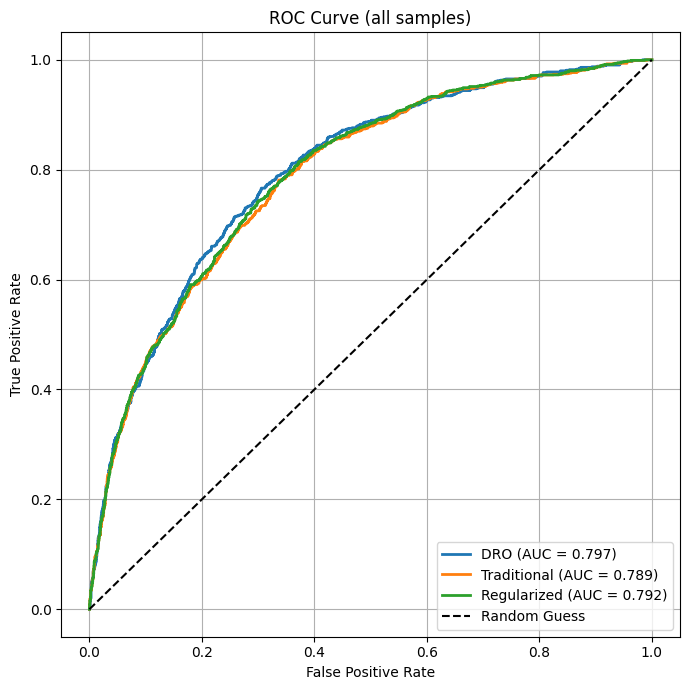

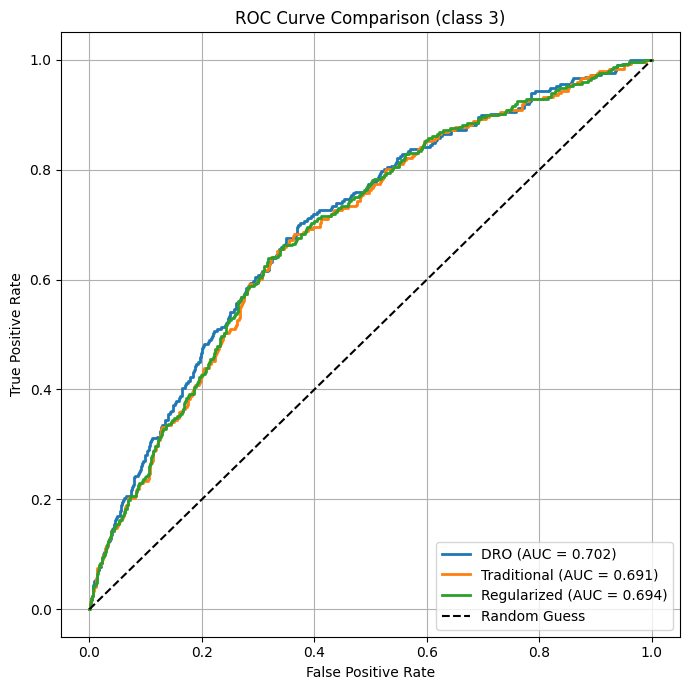

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# =======================
# Step 1: 从tuning结果中拿出概率
# =======================

trad_probs = trad_results["prob_all"]  # (n, 4)
reg_probs = reg_results["prob_all"]
dro_probs = dro_results["prob_all"]

y_true = (data_test["y_{t+1}"] == 3).astype(int).tolist()

trad_4_p = trad_probs.tolist() 
reg_4_p = reg_probs.tolist()
dro_4_p = dro_probs.tolist()



# ROC computation
fpr_dro, tpr_dro, _ = roc_curve(y_true, dro_4_p)
auc_dro = auc(fpr_dro, tpr_dro)

fpr_trad, tpr_trad, _ = roc_curve(y_true, trad_4_p)
auc_trad = auc(fpr_trad, tpr_trad)

fpr_reg, tpr_reg, _ = roc_curve(y_true, reg_4_p)
auc_reg = auc(fpr_reg, tpr_reg)

# Plot
plt.figure(figsize=(7, 7))
plt.plot(fpr_dro, tpr_dro, label=f"DRO (AUC = {auc_dro:.3f})", linewidth=2)
plt.plot(fpr_trad, tpr_trad, label=f"Traditional (AUC = {auc_trad:.3f})", linewidth=2)
plt.plot(fpr_reg, tpr_reg, label=f"Regularized (AUC = {auc_reg:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (all samples)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# =======================
# Step 2: 去除 y_t == 3 的样本
# =======================

indices_to_remove = data_test.index[data_test['y_t'] == 3].tolist()

# 用逆序删除，防止 index 错乱
for idx in sorted(indices_to_remove, reverse=True):
    del trad_4_p[idx]
    del reg_4_p[idx]
    del dro_4_p[idx]
    del y_true[idx]

# =======================
# Step 3: 计算新的ROC曲线
# =======================

fpr_dro, tpr_dro, _ = roc_curve(y_true, dro_4_p)
auc_dro = auc(fpr_dro, tpr_dro)

fpr_trad, tpr_trad, _ = roc_curve(y_true, trad_4_p)
auc_trad = auc(fpr_trad, tpr_trad)

fpr_reg, tpr_reg, _ = roc_curve(y_true, reg_4_p)
auc_reg = auc(fpr_reg, tpr_reg)

# =======================
# Step 4: 画图
# =======================

plt.figure(figsize=(7, 7))
plt.plot(fpr_dro, tpr_dro, label=f"DRO (AUC = {auc_dro:.3f})", linewidth=2)
plt.plot(fpr_trad, tpr_trad, label=f"Traditional (AUC = {auc_trad:.3f})", linewidth=2)
plt.plot(fpr_reg, tpr_reg, label=f"Regularized (AUC = {auc_reg:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (class 3)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 16.50it/s]


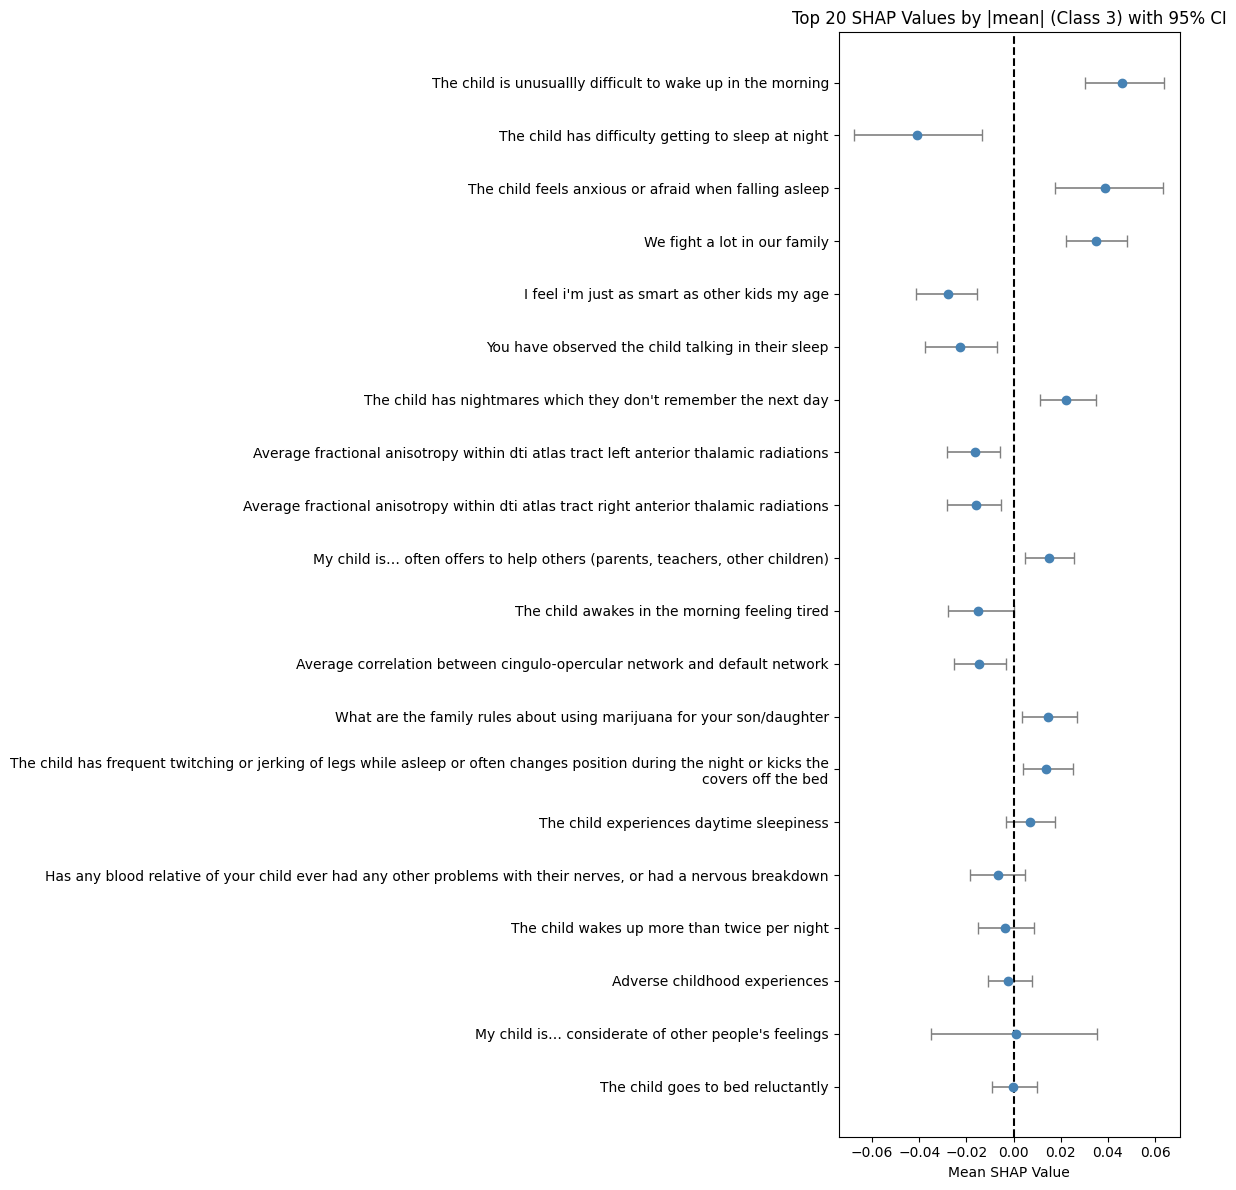

In [13]:
from src.utils_shap import compute_and_plot_shap_kernel_autoquestion

X_np = X_train  
summary = compute_and_plot_shap_kernel_autoquestion(
    trad_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:11<00:00, 16.74it/s]


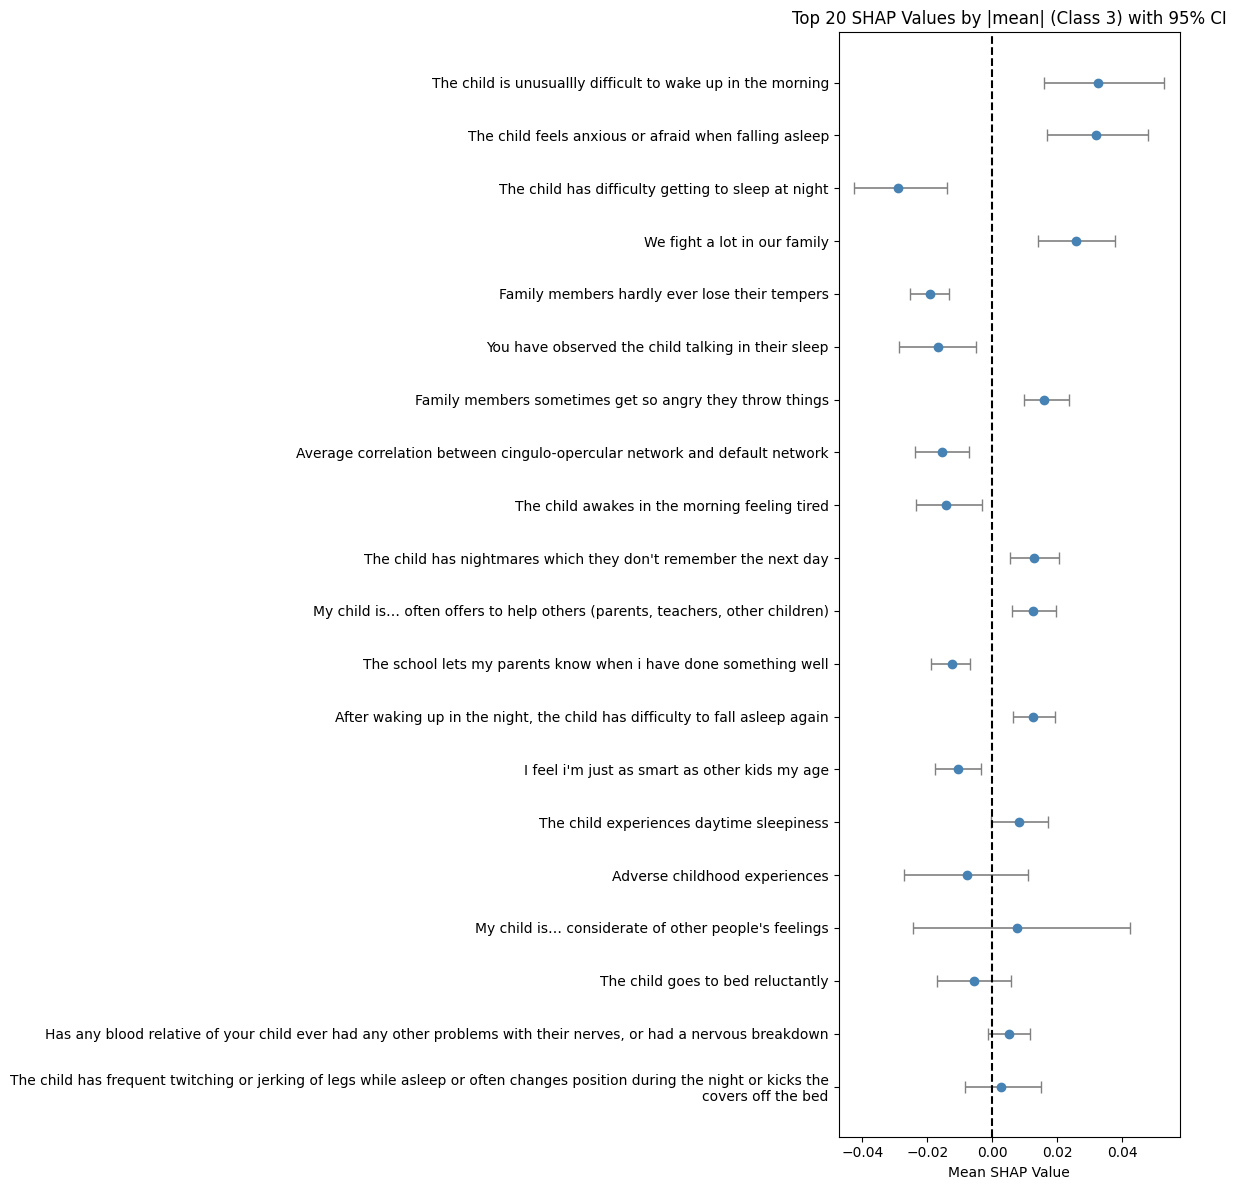

In [14]:
summary = compute_and_plot_shap_kernel_autoquestion(
    reg_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:11<00:00, 16.74it/s]


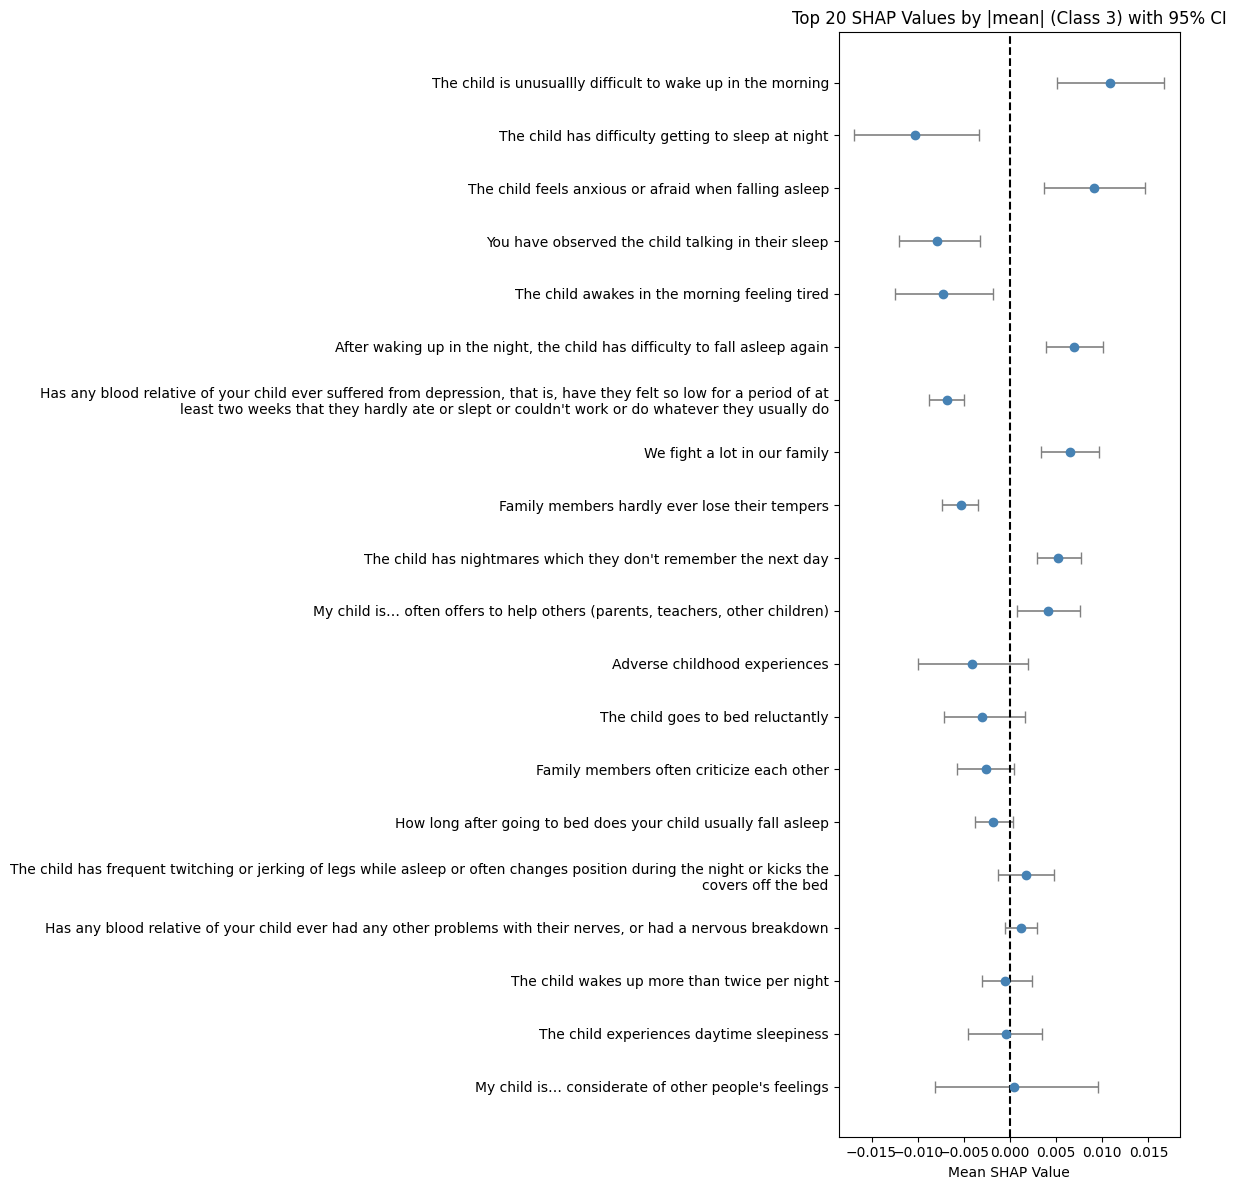

In [15]:
summary = compute_and_plot_shap_kernel_autoquestion(
    dro_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)